# Important Notes

- to prevent overfitting to outliers using MAE loss, we used log transformation of the measured and inferred BNPP values when calculating BNPP loss
- Weights acquired from the first stage of training(BNPP) were frozen, except for the fully connected layers at the end of the model: one for BNPP and one for BNP. Both BNP and BNPP datasets were used to train the stage 2 model to jointly predict BNP and BNPP from a chest radiograph.
- ensures that for each epoch for stage 2, the entire BNP training set was used (n =1124), while an equal number of BNPP labeled images were randomly sampled without replacement from the BNPP training dataset
- ROC curves were computed after binary thresholding of BNP and BNPP measurements, according to previously established screening thresholds for acute heart failure detection (greater than 400 for BNPP, greater than 100 for BNP)

## Imports and Read Ins
'''{toggle}'''

In [85]:
!pip install pytorch_lightning==1.7.7
!pip install torchvision
!pip install --upgrade torch torchvision
!pip install h5py==3.3.0
!pip install -U kaleido

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
import torch
import math
import torch.nn as nn
import pandas as pd
import os, time, sys
import numpy as np
import pytorch_lightning as pl
import h5py
sys.path.append(os.path.dirname(os.path.realpath('.')))
from torchvision.models import resnet152, ResNet152_Weights
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as Func
from torchvision import transforms as T
from PIL import Image
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score
import glob
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
pio.renderers.default = 'svg'
pio.templates.default = 'plotly_white'

In [2]:
from helpers.lightning_interface import *

## DataSet

In [3]:
DATA_PATH = '/home/jmryan/teams/dsc-180a---a14-[88137]/df_bnpp_datapaths.csv'
KEY_PATH = '/home/jmryan/teams/dsc-180a---a14-[88137]/df_bnpp_keys.csv'

In [4]:
df_datapaths = pd.read_csv(DATA_PATH, header=None).T.merge(pd.read_csv(KEY_PATH, header=None).T, left_index=True, right_index=True)

In [5]:
## Read in, combine and clean
df_datapaths = pd.read_csv(DATA_PATH, header=None).T.merge(pd.read_csv(KEY_PATH, header=None).T, left_index=True, right_index=True)
df_datapaths.columns = ['filepaths', 'key']
df_datapaths.key = df_datapaths.key.apply(lambda x: eval(x))
df_datapaths.filepaths = df_datapaths.filepaths.apply(lambda x: eval(x))
df_datapaths = df_datapaths.set_index('key')

## Clean train, val, test
cols= ['unique_key', 'bnpp_value_log', 'BNPP_weight', 'PNA_mask', 'PNA_wight_mask', 'BNP_value', 'age_at_sampletime']
test_df = pd.read_csv('bnpp_test.csv', usecols = cols).set_index('unique_key')
train_df = pd.read_csv('bnpp_train.csv', usecols = cols).set_index('unique_key')
val_df = pd.read_csv('bnpp_val.csv', usecols = cols).set_index('unique_key')
train_df['heart'] = train_df['BNP_value'].apply(lambda x: int(x > 400))
test_df['heart'] = test_df['BNP_value'].apply(lambda x: int(x > 400))
val_df['heart'] = val_df['BNP_value'].apply(lambda x: int(x > 400))
all_df = pd.concat([train_df, val_df, test_df])

## Combo w df_datapaths
train_df = train_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
test_df = test_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
val_df = val_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)

## Class
class PreprocessedImageDataset(Dataset):
    def __init__(self, df, transform=None, target_transform=None):
        self.df = df
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df[idx]
        filepath = row[7]  
        val = row[0]
        heart = row[6]
        im = torch.load(filepath)
        return im.view(1, 224, 224).expand(3, -1, -1), val, heart

In [8]:
class ResNet152_Transform(object):
    def __init__(self, composed):
        self.composed = composed
    
    def __call__(self, sample):
#         data_tr = torch.moveaxis(sample, 1, 0)
        #print(sample)
        print(sample.shape)
        im = self.composed(sample).detach()
        #print(im)
        return im

In [9]:
resnet152_trnsf = ResNet152_Transform(transforms.Compose([
    #T.ToPILImage(),
    T.Resize([224, 224], interpolation=T.InterpolationMode.BILINEAR),
    T.ToTensor(),
    #T.Normalize(0.49459884, 0.0918)
]))

In [10]:
hf_path = '/home/jmryan/teams/dsc-180a---a14-[88137]/bnpp_frontalonly_1024_'
hf_paths = []
hfs = []
for i in range(11):
    #print(os.path.exists(hf_path+str(i)+'.hdf5'))
    if i >= 7 and i != 10:
        continue
    hf_paths.append(hf_path+str(i)+'.hdf5')
    hfs.append(h5py.File(hf_path+str(i)+'.hdf5', 'r'))
    print(i)

0
1
2
3
4
5
6
10


In [11]:
cols= ['unique_key', 'bnpp_value_log', 'BNPP_weight', 'PNA_mask', 'PNA_wight_mask', 'BNP_value', 'age_at_sampletime']
test_df = pd.read_csv('bnpp_test.csv', usecols = cols).set_index('unique_key')
train_df = pd.read_csv('bnpp_train.csv', usecols = cols).set_index('unique_key')
val_df = pd.read_csv('bnpp_val.csv', usecols = cols).set_index('unique_key')
train_df['heart'] = train_df['BNP_value'].apply(lambda x: int(x > 400))
test_df['heart'] = test_df['BNP_value'].apply(lambda x: int(x > 400))
val_df['heart'] = val_df['BNP_value'].apply(lambda x: int(x > 400))
all_df = pd.concat([train_df, val_df, test_df])

In [12]:
train_df

,bnpp_value_log,BNPP_weight,PNA_mask,PNA_wight_mask,BNP_value,age_at_sampletime,heart
unique_key,,,,,,,
Flodure_51396672_img1,0.690196,1,None,1,4.9,45,0
Okepik_50995691_img1,0.690196,1,None,1,4.9,53,0
Kuesluco_51713925_img1,0.690196,1,None,1,4.9,54,0
Gumepra_51602745_img1,0.690196,1,None,1,4.9,58,0
Gapeklik_51060218_img1,0.690196,1,None,1,4.9,19,0
...,...,...,...,...,...,...,...
Puesrueci_53095611_img1,4.845099,1,None,1,70000.1,57,1
Adakas_52269723_img1,4.845099,1,None,1,70000.1,73,1
Ekugud_52967627_img1,4.845099,1,None,1,70000.1,53,1


In [13]:
train_df = train_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
test_df = test_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
val_df = val_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)

In [14]:
hfs_keys = []
for hf in hfs:
    hfs_keys.append(list(hf.keys()))

In [15]:
train_locs = {}
val_locs = {}
test_locs = {}
for i in range(len(hfs_keys)):
    for key in hfs_keys[i]:
        if key in train_df.index:
            train_locs[key] = i
        elif key in val_df.index:
            val_locs[key] = i
        elif key in test_df.index:
            test_locs[key] = i

In [16]:
train_locs_df = pd.DataFrame(train_locs, index=[1]).T
train_locs_df.columns = ['hf_loc']
val_locs_df = pd.DataFrame(val_locs, index=[1]).T
val_locs_df.columns = ['hf_loc']
test_locs_df = pd.DataFrame(test_locs, index=[1]).T
test_locs_df.columns = ['hf_loc']

In [17]:
train_df = train_df.merge(train_locs_df, how='inner', left_index=True, right_index=True)
val_df = val_df.merge(val_locs_df, how='inner', left_index=True, right_index=True)
test_df = test_df.merge(test_locs_df, how='inner', left_index=True, right_index=True)

In [21]:
os.getcwd()

'/home/jmryan/private/DSC180/A'

In [29]:
from sklearn.model_selection import train_test_split

In [31]:
ttt, tts = train_test_split(test_df, test_size=0.1)

In [32]:
ttt

,bnpp_value_log,BNPP_weight,PNA_mask,PNA_wight_mask,BNP_value,age_at_sampletime,heart,filepaths,hf_loc
Ureflof_51229296_img1,2.892651,1,None,1,781.0,75,1,/home/jmryan/teams/dsc-180a---a14-[88137]/bnpp...,7
Lurhendup_51620338_img1,2.700704,1,None,1,502.0,73,1,/home/jmryan/teams/dsc-180a---a14-[88137]/bnpp...,5
Klemomus_51851945_img1,2.758912,1,None,1,574.0,58,1,/home/jmryan/teams/dsc-180a---a14-[88137]/bnpp...,4
Gajanoy_50982247_img1,1.531479,1,None,1,34.0,28,0,/home/jmryan/teams/dsc-180a---a14-[88137]/bnpp...,2
Gojoki_53040007_img1,3.501196,1,None,1,3171.0,92,1,/home/jmryan/teams/dsc-180a---a14-[88137]/bnpp...,3
...,...,...,...,...,...,...,...,...,...
Jehibop_50637310_img1,2.212188,1,None,1,163.0,82,0,/home/jmryan/teams/dsc-180a---a14-[88137]/bnpp...,4
Oyagey_52658122_img1,4.142076,1,None,1,13870.0,84,1,/home/jmryan/teams/dsc-180a---a14-[88137]/bnpp...,6
Afiesan_51385672_img1,3.481443,1,None,1,3030.0,57,1,/home/jmryan/teams/dsc-180a---a14-[88137]/bnpp...,0
Onosed_51308748_img1,3.719165,1,None,1,5238.0,61,1,/home/jmryan/teams/dsc-180a---a14-[88137]/bnpp...,6


In [25]:
train_df.to_csv('/home/jmryan/private/DSC180/A/train/traindata.csv')

In [26]:
val_df.to_csv('/home/jmryan/private/DSC180/A/val/valdata.csv')

In [23]:
test_df.to_csv('/home/jmryan/private/DSC180/A/test/testdata.csv')

In [17]:
class PreprocessedImageDataset(Dataset):
    def __init__(self, df, transform=None, target_transform=None):
        self.df = df
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df[idx]
        filepath = row[7]  
        val = row[0]
        heart = row[6]
        im = torch.load(filepath)
        return im.view(1, 224, 224).expand(3, -1, -1), val, heart

In [18]:
class ImageDataset(Dataset):
    def __init__(self, hfs, df, transform=None, target_transform=None, use_one = True):
        self.use_one = use_one
        if use_one:
            self.hfs = hfs[0]
        else:
            self.hfs = np.array(hfs)
        self.df = df
        self.transform = transform
        self.pil = T.ToPILImage()
        self.tens = T.ToTensor()
        self.resize = T.Resize([224, 224], interpolation=T.InterpolationMode.BILINEAR)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        key = self.df.index[idx]
        if self.use_one:
            im = np.array(self.hfs[key][:,:])
        else:
            which_hf = int(self.df.iloc[idx].hf_loc)
            im = self.hfs[which_hf][key][:,:]
        val = self.df.loc[key].bnpp_value_log
        heart = self.df.loc[key].heart
        im = (im-im.min())/(im.max() - im.min())
        im = self.tens(self.resize(self.pil(im.copy())))[0]
        return im.view(1, 224, 224).expand(3, -1, -1), val, heart

In [19]:
train_dataset = ImageDataset(hfs, df = train_df[train_df.hf_loc == 0], transform=transforms.Compose([resnet152_trnsf]))
val_dataset = ImageDataset(hfs, df=val_df[val_df.hf_loc == 0], transform=transforms.Compose([resnet152_trnsf]))

In [18]:
train_dataset = PreprocessedImageDataset(df=train_df.to_numpy())
val_dataset = PreprocessedImageDataset(df=val_df.to_numpy())

In [19]:
train_dataset[3]

(tensor([[[0.0825, 0.0605, 0.0498,  ..., 0.0099, 0.0113, 0.0161],
          [0.0654, 0.0462, 0.0351,  ..., 0.0068, 0.0085, 0.0125],
          [0.0523, 0.0358, 0.0251,  ..., 0.0046, 0.0059, 0.0097],
          ...,
          [0.7798, 0.7526, 0.7311,  ..., 0.6815, 0.6800, 0.6921],
          [0.7781, 0.7520, 0.7326,  ..., 0.6955, 0.6959, 0.7053],
          [0.7823, 0.7559, 0.7354,  ..., 0.7190, 0.7173, 0.7265]],
 
         [[0.0825, 0.0605, 0.0498,  ..., 0.0099, 0.0113, 0.0161],
          [0.0654, 0.0462, 0.0351,  ..., 0.0068, 0.0085, 0.0125],
          [0.0523, 0.0358, 0.0251,  ..., 0.0046, 0.0059, 0.0097],
          ...,
          [0.7798, 0.7526, 0.7311,  ..., 0.6815, 0.6800, 0.6921],
          [0.7781, 0.7520, 0.7326,  ..., 0.6955, 0.6959, 0.7053],
          [0.7823, 0.7559, 0.7354,  ..., 0.7190, 0.7173, 0.7265]],
 
         [[0.0825, 0.0605, 0.0498,  ..., 0.0099, 0.0113, 0.0161],
          [0.0654, 0.0462, 0.0351,  ..., 0.0068, 0.0085, 0.0125],
          [0.0523, 0.0358, 0.0251,  ...,

In [20]:
COLLATE_SIZE = (224, 224)

In [21]:
def collate_fn_xray(data):
    x, y, heart = list(zip(*data))
    
    # handle malformed data:
    msk = [x_i.shape == COLLATE_SIZE for x_i in x]
    x = [x_i for x_i in x if x_i.shape == COLLATE_SIZE]
    y = [y_i for i, y_i in enumerate(y) if msk[i]]
    heart = [heart_i for i, heart_i in enumerate(heart) if msk[i]]
    
    # if everythin is malformed
    if len(x) == 0:
        return torch.tensor([]), torch.tensor([]), np.array([])
        
    return torch.stack(x), y, heart

In [22]:
BATCH_SIZE = 32
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers = 0, shuffle=False)

## BNPP Metrics

In [13]:
all_df

,bnpp_value_log,BNPP_weight,PNA_mask,PNA_wight_mask,BNP_value,age_at_sampletime,BNP_value.1,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
unique_key,,,,,,,,,,,,,,,,,
Flodure_51396672_img1,0.690196,1.0,None,1.0,4.9,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Okepik_50995691_img1,0.690196,1.0,None,1.0,4.9,53.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kuesluco_51713925_img1,0.690196,1.0,None,1.0,4.9,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gumepra_51602745_img1,0.690196,1.0,None,1.0,4.9,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gapeklik_51060218_img1,0.690196,1.0,None,1.0,4.9,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Eslinik_51387018_img1,4.845099,1.0,None,1.0,70000.1,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Padaswou_51641346_img1,4.845099,1.0,None,1.0,70000.1,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Crifape_51290561_img1,4.845099,1.0,None,1.0,70000.1,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [149]:
ids = pd.concat([pd.Series(test_df.index), pd.Series(train_df.index), pd.Series(val_df.index)]).iloc[:-1].to_numpy()
in_ = []
hf_keys = list(hf.keys())
for im in ids:
    if im in hf_keys:
        in_.append(im)
actual_all = all_df.loc[in_]

In [150]:
def age_helper(x):
    if x > 90:
        return '> 90'
    elif x > 80:
        return '> 80'
    elif x > 70:
        return '> 70'
    elif x > 60:
        return '> 60'
    elif x > 50:
        return '> 50'
    elif x > 40:
        return '> 40'
    elif x > 30: 
        return '> 30'
    elif x >= 20:
        return '> 20'

In [151]:
actual_all['age_group'] = actual_all['age_at_sampletime'].apply(age_helper)

### Whole Set Stats

In [162]:
stats_bnpp = [actual_all.BNP_value.mean(), actual_all.BNP_value.std(), actual_all.BNP_value.min(), actual_all.BNP_value.max(),
 actual_all.BNP_value.median(), len(actual_all.BNP_value)]
pd.DataFrame(stats_bnpp, index = ['Mean', 'STD', 'Min', 'Max', 'Median', 'Count'], columns=['BNPP'])

,BNPP
Mean,4958.361048
STD,10944.872530
Min,4.900000
Max,70000.100000
Median,937.500000
Count,706.000000


In [168]:
stats_heart = [actual_all.heart.mean(), actual_all.heart.sum(), len(actual_all.heart)]
pd.DataFrame(stats_heart, index = ['Mean', 'Sum', 'Count'], columns=['Is Heart'])

,Is Heart
Mean,0.637394
Sum,450.000000
Count,706.000000


### Age group breakdown for BNPP Raw

In [159]:
actual_all[['age_group', 'BNP_value']].groupby('age_group').agg(
    ['mean', 'std', 'min', 'max', 'median', 'count']).sort_index()

BNP_value                                           
                  mean           std   min      max  median count
age_group                                                        
> 20       5391.504167  14767.180635   6.0  70000.1   252.0    24
> 30       3816.414286   8689.215551   4.9  37905.0   471.0    35
> 40       4397.902597   9858.064132   4.9  54607.0   403.0    77
> 50       3885.609589   9997.732103   4.9  70000.1   623.0   146
> 60       6100.635922  12662.312680   4.9  70000.1  1212.5   206
> 70       5176.419048  11203.797668  22.0  70000.1  1371.0   126
> 80       4440.040541   7282.442271  32.0  34989.0  1548.5    74
> 90       5231.777778  10903.987806  99.0  41461.0   894.0    18

### Age group breakdown for BNPP Class

In [158]:
actual_all[['age_group', 'heart']].groupby('age_group').agg(
    ['mean', 'sum', 'count'])

heart           
               mean  sum count
age_group                     
> 20       0.458333   11    24
> 30       0.571429   20    35
> 40       0.506494   39    77
> 50       0.554795   81   146
> 60       0.674757  139   206
> 70       0.706349   89   126
> 80       0.756757   56    74
> 90       0.833333   15    18

## Model

1861.9999999999986


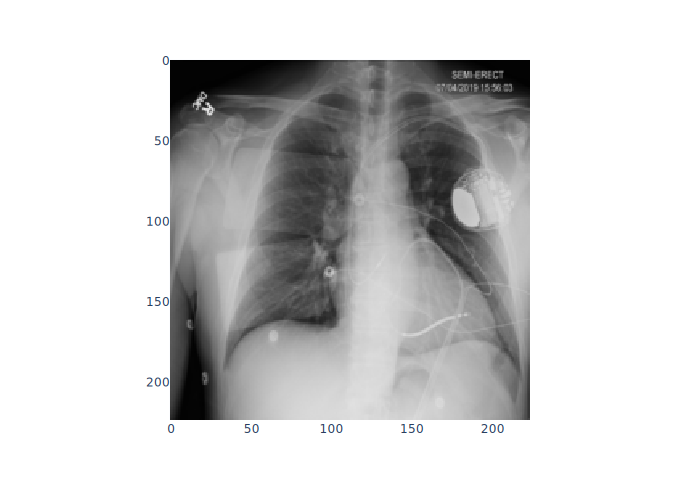

In [29]:
for x,y, _ in train_dl:
    print(10 ** y[0].item())
    px.imshow(x[0].permute(1, 2, 0).numpy()).show()
    break

### SuperNet

In [23]:
model = resnet152(weights=ResNet152_Weights.DEFAULT)

In [24]:
class SuperNet(SuperFace):
    def __init__(self, layer_defs, lr = 1e-3, is_transfer=False, model=None, lr_scheduler = []):
        super().__init__(layer_defs, lr_scheduler = lr_scheduler, lr=lr)
        
        self.model = model
        self.grad = False
        self.val_heart_true_epoch = np.array([])
        self.val_heart_hat_epoch = np.array([])
        self.train_heart_true_epoch = np.array([])
        self.train_heart_hat_epoch = np.array([])
        self.val_mae_epoch = np.array([])
        self.train_mae_epoch = np.array([])
        self.train_loss_epoch = np.array([])
        self.val_loss_epoch = np.array([])
            
    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=self.lr) 
        lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, verbose=True)
        return {"optimizer": optim, "lr_scheduler": {'scheduler': lr_sched, 'monitor': 'loss', 
                                                     'interval': 'epoch'}}
    
    def init_model(self):
        layers = list(model.children())
        lin = layers[-1]
        layers = layers[:-1]
        self.regresser = nn.Sequential(nn.Linear(lin.in_features, lin.in_features), 
                                       nn.Linear(lin.in_features, 1024),
                                       nn.Linear(1024, 526),
                                       nn.Linear(526, 1))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.grad:
            represents = self.layers(x).flatten(1)
            y_hat = self.regresser(represents)
        else:
            with torch.no_grad():
                represents = self.layers(x).flatten(1)
            y_hat = self.regresser(represents)
        del x
        return y_hat
    
    
    def turn_grad(self, boo):
        self.grad = boo
    
    def training_step(self, batch, batch_idx):
        x, y, heart = batch
        
        y_hat = self(x)
        #print(y_hat.detach().mean().item(), y.mean().item(), y_hat.detach().median().item(), y.median().item())
        del x
        
#         loss = self.loss_func(y_hat, y)
        
        loss = self.mae(y_hat, y)
        
        m_a_e = self.mae(y_hat, y).detach()
        
        y_heart = ((10**y_hat) > 400).long()
        
        loss_dic = {'loss': loss,
                    'y_hat': y_hat,
                    'y_true': y,
                    'heart_true': heart,
                    'heart_hat': y_heart,
                    'mae': m_a_e
                   }
        
        return loss_dic
    
    def validation_step(self, batch, batch_idx):
        x, y, heart = batch
        
        y_hat = self(x)
        del x
#         loss = self.loss_func(y_hat, y)
        
        m_a_e = self.mae(y_hat, y).detach()
        
        loss = self.mae(y_hat, y).detach()

        y_heart = ((10**y_hat) > 400).long()
        
        loss_dic = {'loss': loss,
                    'y_hat': y_hat,
                    'y_true': y,
                    'heart_true': heart,
                    'heart_hat': y_heart,
                    'mae': m_a_e
                   }
        
        return loss_dic
    
        
    def training_step_end(self, batch_loss):
        total_loss = batch_loss['loss'].mean()
        heart_true = batch_loss['heart_true'].to('cpu').numpy()
        heart_hat = batch_loss['heart_hat'].to('cpu').numpy()
        step_mae = batch_loss['mae'].to('cpu').numpy()
        
        self.train_heart_true_epoch = np.append(self.train_heart_true_epoch, heart_true)
        self.train_heart_hat_epoch = np.append(self.train_heart_hat_epoch, heart_hat)
        self.train_mae_epoch = np.append(self.train_mae_epoch, step_mae)
        
        torch.cuda.empty_cache()
        out = 'training_step (pre del) mem %:', torch.cuda.memory_allocated() / torch.cuda.max_memory_allocated()
        #print(out)        
        return total_loss
    
    def validation_step_end(self, batch_loss):
        total_loss = batch_loss['loss'].mean()
        heart_true = batch_loss['heart_true'].to('cpu').numpy()
        heart_hat = batch_loss['heart_hat'].to('cpu').numpy()
        step_mae = batch_loss['mae'].to('cpu').numpy()
        
        self.val_heart_true_epoch = np.append(self.val_heart_true_epoch, heart_true)
        self.val_heart_hat_epoch = np.append(self.val_heart_hat_epoch, heart_hat)
        self.val_mae_epoch = np.append(self.val_mae_epoch, step_mae)
        
        return total_loss
        
    def training_epoch_end(self, step_outputs):
        
        losses = [loss['loss'] for loss in step_outputs]
        
        heart_true = self.train_heart_true_epoch
        heart_hat = self.train_heart_hat_epoch
        epoch_mae = self.train_mae_epoch
        total_loss = sum(losses)/len(losses)
        auc = roc_auc_score(heart_true, heart_hat)
        prc = precision_score(heart_true, heart_hat, zero_division=0)
        
# #         self.log('train_AUC', auc,
#                 on_step=False, on_epoch=True, prog_bar=True, batch_size=BATCH_SIZE)
        
#         self.log('train_PRC', prc,
#                 on_step=False, on_epoch=True, prog_bar=True, batch_size=BATCH_SIZE)
        
        self.log('loss', total_loss,
                on_step=False, on_epoch=True, prog_bar=False, batch_size=BATCH_SIZE)
        
        
        info_dic = {'AUC': auc, 'PRC': prc, 'loss':total_loss.item()}
        
        print(f"Epoch {self.current_epoch}")
        print(f"\tTrain {info_dic}; mean_mae: {epoch_mae.mean()};" + 
             f" mean_heart_hat: {heart_hat.mean()}; mean_heart_true: {heart_true.mean()}")
#        print(f"\tTrain loss: {total_loss.item()}; mean_mae: {epoch_mae.mean()};" + 
 #            f" mean_heart_hat: {heart_hat.mean()}; mean_heart_true: {heart_true.mean()}")
        
        self.train_loss_epoch = np.append(self.train_loss_epoch, total_loss.item())
        
        self.train_heart_true_epoch = np.array([])
        self.train_heart_hat_epoch = np.array([])
        self.train_mae_epoch = np.array([])
        sch = self.lr_schedulers()
        print(self.lr_schedulers())

        # If the selected scheduler is a ReduceLROnPlateau scheduler.

        return None
        
    def validation_epoch_end(self, step_outputs):
        losses = step_outputs

        heart_true = self.val_heart_true_epoch
        heart_hat = self.val_heart_hat_epoch
        epoch_mae = self.val_mae_epoch
        total_loss = sum(losses)/len(losses)

        auc = roc_auc_score(heart_true, heart_hat)
        prc = precision_score(heart_true, heart_hat, zero_division=0)

#         self.log('val_AUC', auc,
#                 on_step=False, on_epoch=True, prog_bar=True, batch_size=BATCH_SIZE)
        
#         self.log('val_PRC', prc,
#                 on_step=False, on_epoch=True, prog_bar=True, batch_size=BATCH_SIZE)
        
# #         self.log('val_loss', total_loss,
#                 on_step=False, on_epoch=True, prog_bar=True, batch_size=BATCH_SIZE)
        
        
        info_dic = {'AUC': auc, 'PRC': prc,'loss': total_loss.item()}
        
        print(f"\tVal {info_dic}; mean_mae: {epoch_mae.mean()};" + 
             f" mean_heart_hat: {heart_hat.mean()}; mean_heart_true: {heart_true.mean()}")
#         print(f"\tVal loss: {total_loss.item()}; mean_mae: {epoch_mae.mean()};" + 
#              f" mean_heart_hat: {heart_hat.mean()}; mean_heart_true: {heart_true.mean()}")
        
        self.val_heart_true_epoch = np.array([])
        self.val_heart_hat_epoch = np.array([])
        self.val_mae_epoch = np.array([])
        self.val_loss_epoch = np.append(self.val_loss_epoch, total_loss.item())

        
        return None
        
    def loss_func(self, y_hat, y_true):
        y_true = y_true.view(-1, 1)
        return torch.abs(torch.log(1 + y_true) - torch.log(1 + y_hat))
    
    def mae(self, y_hat, y_true):
        y_true = y_true.view(-1,1)
        return torch.abs(y_true - y_hat)

### Train

In [25]:
torch.cuda.is_available()

True

In [26]:
os.cpu_count()

80

In [27]:
net = SuperNet(layer_defs=None, is_transfer=True, model = model, lr_scheduler=True, lr = 1e-5)

In [28]:
net.regresser

Sequential(
  (0): Linear(in_features=2048, out_features=2048, bias=True)
  (1): Linear(in_features=2048, out_features=1024, bias=True)
  (2): Linear(in_features=1024, out_features=526, bias=True)
  (3): Linear(in_features=526, out_features=1, bias=True)
)

In [50]:
trainer = pl.Trainer(
    accelerator='gpu',
    max_epochs=100, 
    enable_progress_bar=False,
    logger=False,
    enable_checkpointing=False
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [51]:
net.train()
trainer.fit(net, train_dl, val_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | regresser | Sequential | 6.8 M 
1 | layers    | Sequential | 58.1 M
2 | model     | ResNet     | 60.2 M
-----------------------------------------
67.0 M    Trainable params
0         Non-trainable params
67.0 M    Total params
268.108   Total estimated model params size (MB)
/home/jmryan/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning:

The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



	Val {'AUC': 0.5, 'PRC': 0.0, 'loss': 2.7797352299714353}; mean_mae: 2.7797352299714353; mean_heart_hat: 0.0; mean_heart_true: 0.546875


/home/jmryan/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



	Val {'AUC': 0.6277806803668873, 'PRC': 0.7273567467652495, 'loss': 0.7146267506055141}; mean_mae: 0.7150259247282239; mean_heart_hat: 0.5656037637219028; mean_heart_true: 0.6210141139571353
Epoch 0
	Train {'AUC': 0.5593988143171518, 'PRC': 0.6762589928057554, 'loss': 0.8901356352804045}; mean_mae: 0.8902138915204959; mean_heart_hat: 0.6141519388024268; mean_heart_true: 0.6312318649432868
	Val {'AUC': 0.6305201439684198, 'PRC': 0.7020689655172414, 'loss': 0.670911503028036}; mean_mae: 0.671116435900647; mean_heart_hat: 0.7579717720857292; mean_heart_true: 0.6210141139571353
Epoch 1
	Train {'AUC': 0.6197310332891535, 'PRC': 0.7119793656858999, 'loss': 0.6830951021684994}; mean_mae: 0.683133003639053; mean_heart_hat: 0.6903191769981535; mean_heart_true: 0.6312318649432868
	Val {'AUC': 0.6516974341112273, 'PRC': 0.7228017883755589, 'loss': 0.6571024787696079}; mean_mae: 0.6573924699315745; mean_heart_hat: 0.7015159435441715; mean_heart_true: 0.6210141139571353
Epoch 2
	Train {'AUC': 0.642

	Val {'AUC': 0.6761854173923139, 'PRC': 0.7438080495356038, 'loss': 0.6357966697584918}; mean_mae: 0.6359967740531064; mean_heart_hat: 0.6753789858860428; mean_heart_true: 0.6210141139571353
Epoch 18
	Train {'AUC': 0.6828805792048458, 'PRC': 0.7519162460272948, 'loss': 0.5952228207064636}; mean_mae: 0.5952423496341163; mean_heart_hat: 0.7054866789765234; mean_heart_true: 0.6312318649432868
	Val {'AUC': 0.654983164983165, 'PRC': 0.723404255319149, 'loss': 0.6385067268467886}; mean_mae: 0.6387003970473328; mean_heart_hat: 0.7124934657605855; mean_heart_true: 0.6210141139571353
Epoch 19
	Train {'AUC': 0.6900119462045654, 'PRC': 0.7556338681257535, 'loss': 0.5933780061693165}; mean_mae: 0.5933962650421857; mean_heart_hat: 0.7110920601424426; mean_heart_true: 0.6312318649432868
	Val {'AUC': 0.6770834784627887, 'PRC': 0.7491961414790996, 'loss': 0.6367875517617161}; mean_mae: 0.6370106732975633; mean_heart_hat: 0.6502875065342394; mean_heart_true: 0.6210141139571353
Epoch 20
	Train {'AUC': 0

	Val {'AUC': 0.6787275049344015, 'PRC': 0.7615720524017467, 'loss': 0.6418182275686813}; mean_mae: 0.6418826353008626; mean_heart_hat: 0.5985363303711448; mean_heart_true: 0.6210141139571353
Epoch 36
	Train {'AUC': 0.6880688384158135, 'PRC': 0.7537368518176786, 'loss': 0.5844411483280867}; mean_mae: 0.5844539940513345; mean_heart_hat: 0.7147190714850963; mean_heart_true: 0.6312318649432868
	Val {'AUC': 0.6791774062463717, 'PRC': 0.7472613458528952, 'loss': 0.6312263512645571}; mean_mae: 0.6312647604248582; mean_heart_hat: 0.6680606377417668; mean_heart_true: 0.6210141139571353
Epoch 37
	Train {'AUC': 0.6926242536798136, 'PRC': 0.7584175084175084, 'loss': 0.5874967732338026}; mean_mae: 0.5875147896111369; mean_heart_hat: 0.7050910050118702; mean_heart_true: 0.6312318649432868
	Val {'AUC': 0.6625589225589226, 'PRC': 0.7270094134685011, 'loss': 0.6326843259200793}; mean_mae: 0.6328050104085037; mean_heart_hat: 0.7219027705175117; mean_heart_true: 0.6210141139571353
Epoch 38
	Train {'AUC':

	Val {'AUC': 0.6545768025078371, 'PRC': 0.7184873949579832, 'loss': 0.6395152270329889}; mean_mae: 0.6396146761669582; mean_heart_hat: 0.7464715107161526; mean_heart_true: 0.6210141139571353
Epoch 54
	Train {'AUC': 0.6871215341359843, 'PRC': 0.7532323605467307, 'loss': 0.5853626304751463}; mean_mae: 0.5853226286895958; mean_heart_hat: 0.714059614877341; mean_heart_true: 0.6312318649432868
	Val {'AUC': 0.6753999767792871, 'PRC': 0.7483870967741936, 'loss': 0.6324220469932446}; mean_mae: 0.6324719039677756; mean_heart_hat: 0.6481965499215891; mean_heart_true: 0.6210141139571353
Epoch 55
	Train {'AUC': 0.6882645914676031, 'PRC': 0.7534246575342466, 'loss': 0.5821412748736982}; mean_mae: 0.5821205508416047; mean_heart_hat: 0.7172909522553416; mean_heart_true: 0.6312318649432868
	Val {'AUC': 0.6686804829908278, 'PRC': 0.7387596899224806, 'loss': 0.6326206756649136}; mean_mae: 0.6326643590276012; mean_heart_hat: 0.6743335075797178; mean_heart_true: 0.6210141139571353
Epoch 56
	Train {'AUC': 

	Val {'AUC': 0.6561999303378614, 'PRC': 0.722422494592646, 'loss': 0.6344384699588191}; mean_mae: 0.6345781534000718; mean_heart_hat: 0.7250392054364871; mean_heart_true: 0.6210141139571353
Epoch 72
	Train {'AUC': 0.6915790168272148, 'PRC': 0.7563118468510127, 'loss': 0.5837152650216901}; mean_mae: 0.5837291296930374; mean_heart_hat: 0.7130704299657082; mean_heart_true: 0.6312318649432868
	Val {'AUC': 0.6632340647857888, 'PRC': 0.7328767123287672, 'loss': 0.6306375747719019}; mean_mae: 0.6307701476558532; mean_heart_hat: 0.6868792472556194; mean_heart_true: 0.6210141139571353
Epoch 73
	Train {'AUC': 0.687690933020547, 'PRC': 0.7529627928341754, 'loss': 0.5799561480873241}; mean_mae: 0.579961150065011; mean_heart_hat: 0.7178185175415458; mean_heart_true: 0.6312318649432868
	Val {'AUC': 0.6675136421688146, 'PRC': 0.7335820895522388, 'loss': 0.6312687264008033}; mean_mae: 0.6314310303541715; mean_heart_hat: 0.7004704652378463; mean_heart_true: 0.6210141139571353
Epoch 74
	Train {'AUC': 0.

	Val {'AUC': 0.6707285498664809, 'PRC': 0.7353159851301115, 'loss': 0.6274470247863191}; mean_mae: 0.6276049333774067; mean_heart_hat: 0.7030841610036592; mean_heart_true: 0.6210141139571353
Epoch 91
	Train {'AUC': 0.6974567273288149, 'PRC': 0.7594261541291153, 'loss': 0.5725925553193757}; mean_mae: 0.5726081226442307; mean_heart_hat: 0.717093115273015; mean_heart_true: 0.6312318649432868
	Val {'AUC': 0.6655613607337745, 'PRC': 0.7324364723467862, 'loss': 0.6288059499235262}; mean_mae: 0.6289206766938972; mean_heart_hat: 0.6994249869315212; mean_heart_true: 0.6210141139571353
Epoch 92
	Train {'AUC': 0.696219062872338, 'PRC': 0.7586460632818248, 'loss': 0.5713344830185074}; mean_mae: 0.5713571797562619; mean_heart_hat: 0.716961223951464; mean_heart_true: 0.6312318649432868
	Val {'AUC': 0.6615650760478347, 'PRC': 0.7267441860465116, 'loss': 0.6274381072486901}; mean_mae: 0.6275975472716456; mean_heart_hat: 0.7192890747516989; mean_heart_true: 0.6210141139571353
Epoch 93
	Train {'AUC': 0.

`Trainer.fit` stopped: `max_epochs=100` reached.


	Val {'AUC': 0.671382793451759, 'PRC': 0.7365269461077845, 'loss': 0.6250257557739478}; mean_mae: 0.6250899174827028; mean_heart_hat: 0.698379508625196; mean_heart_true: 0.6210141139571353
Epoch 99
	Train {'AUC': 0.699807333262789, 'PRC': 0.7604176206612328, 'loss': 0.5688572459182724}; mean_mae: 0.5688189501960801; mean_heart_hat: 0.7200606700079135; mean_heart_true: 0.6312318649432868


Best Val AUC: 65%, using three linear layers

In [113]:
net.configure_optimizers()

{'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     eps: 1e-08
     foreach: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ),
 'lr_scheduler': {'scheduler': <torch.optim.lr_scheduler.ReduceLROnPlateau at 0x7efb60567fd0>,
  'monitor': 'loss',
  'interval': 'epoch'}}

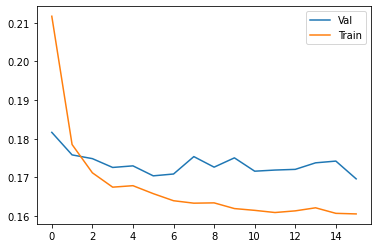

In [121]:
plt.plot(np.arange(len(net.val_loss_epoch) - 1),  net.val_loss_epoch[1:])
plt.plot(np.arange(len(net.train_loss_epoch)),  net.train_loss_epoch)
plt.legend(['Val','Train'])
plt.show()

In [61]:
ex.view(-1,1)

tensor([[1],
        [2],
        [3],
        [4]])

In [190]:
10**.68

4.786300923226384

In [ ]:
## Two optimizers, one loss one auc